In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('./Sample_Superstore.csv', encoding='windows-1252')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.shape

(9994, 21)

In [4]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [5]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

#### Set up data for modeling

In [7]:
df = df[['Order Date', 'Sales']]
df.head()

,Order Date,Sales
0,11/8/2016,261.9600
1,11/8/2016,731.9400
2,6/12/2016,14.6200
3,10/11/2015,957.5775
4,10/11/2015,22.3680


In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [9]:
df = df.resample('W-Mon', on='Order Date').sum().reset_index().sort_values(by='Order Date')

In [10]:
df.shape

(209, 2)

In [11]:
df.dtypes

Order Date    datetime64[ns]
Sales                float64
dtype: object

In [12]:
df.set_index('Order Date', inplace=True)
df.sort_index(inplace=True)

In [13]:
df.head()

,Sales
Order Date,
2014-01-06,4731.144
2014-01-13,3746.267
2014-01-20,3629.202
2014-01-27,1595.188
2014-02-03,1312.752


In [14]:
df.shape

(209, 1)

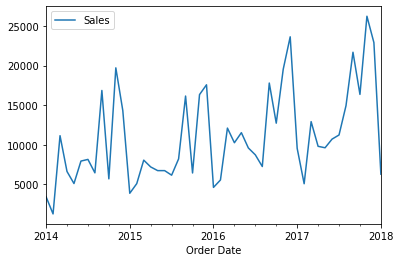

In [15]:
df.resample('M')[['Sales']].mean().plot();

In [16]:
df.rolling(3).mean()

,Sales
Order Date,
2014-01-06,NaN
2014-01-13,NaN
2014-01-20,4035.537667
2014-01-27,2990.219000
2014-02-03,2179.047333
...,...
2017-12-04,27930.819933
2017-12-11,25428.156000
2017-12-18,22961.716000


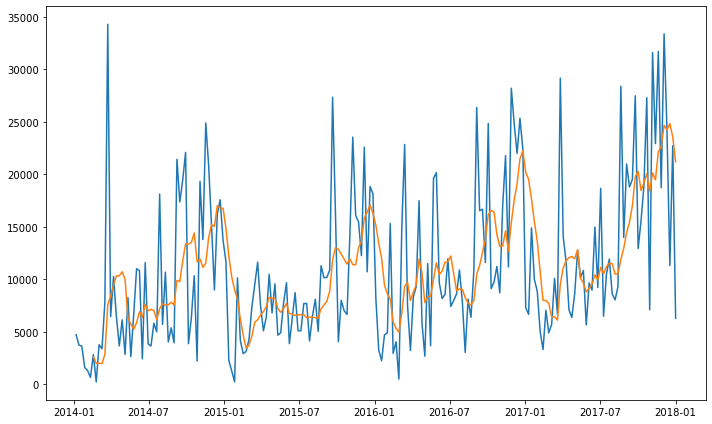

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df['Sales'])
plt.plot(df['Sales'].rolling(7).mean())
# plt.xticks(rotation=45);
plt.tight_layout();

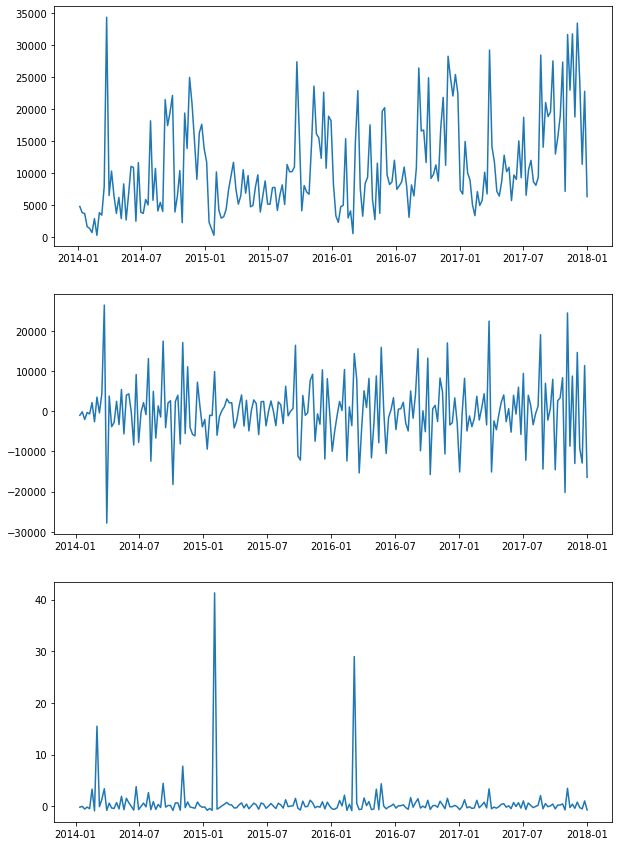

In [18]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
axes[0].plot(df['Sales'])
axes[1].plot(df['Sales'].diff())
axes[2].plot(df['Sales'].pct_change());

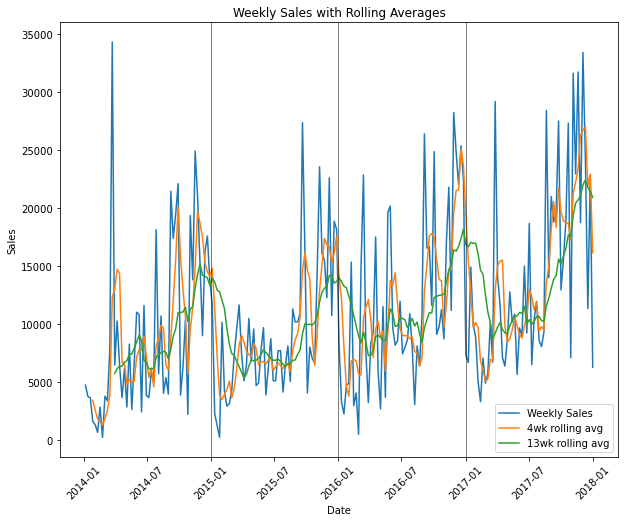

In [19]:
plt.figure(figsize = (10,8))
plt.plot(df['Sales'])
plt.plot(df['Sales'].rolling(4).mean())
plt.plot(df['Sales'].rolling(13).mean())
plt.title('Weekly Sales with Rolling Averages')
plt.xticks(rotation = 45)
plt.axvline(x=['2015-01'], linewidth = 0.5, color='k')
plt.axvline(x=['2016-01'], linewidth = 0.5, color='k')
plt.axvline(x=['2017-01'], linewidth = 0.5, color='k')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Weekly Sales', '4wk rolling avg', '13wk rolling avg']);

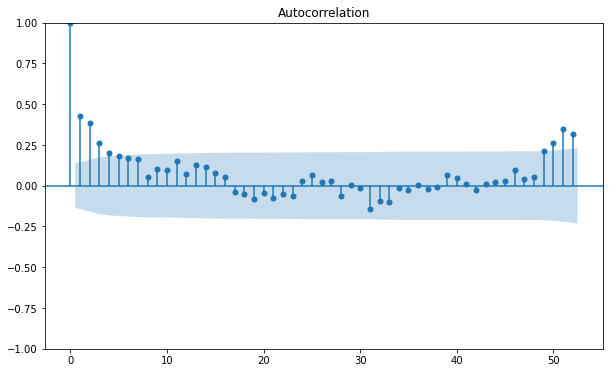

In [20]:
plt.rcParams['figure.figsize'] = (10, 6)
plot_acf(df['Sales'], lags=52);

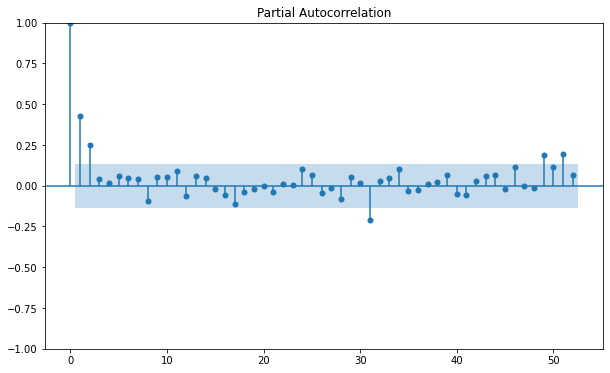

In [21]:
plot_pacf(df['Sales'], lags=52);

#### Baseline Model

In [22]:
df.head()

,Sales
Order Date,
2014-01-06,4731.144
2014-01-13,3746.267
2014-01-20,3629.202
2014-01-27,1595.188
2014-02-03,1312.752


In [23]:
y_train, y_test = train_test_split(df['Sales'], test_size=0.1, shuffle=False, random_state=42)

In [24]:
y_train.shape, y_test.shape

((188,), (21,))

In [25]:
adfuller(df['Sales'])

(-5.9706492081907045,
 1.939912900601648e-07,
 1,
 207,
 {'1%': -3.4623415245233145,
  '5%': -2.875606128263243,
  '10%': -2.574267439846904},
 3931.6681777109857)

In [26]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    p_without = f'p-value without scientific notation:' "{:.17f}".format(float(dfoutput[1]))
    return dfoutput, p_without

In [27]:
interpret_dftest(adfuller(df['Sales']))

(Test Statistic   -5.970649e+00
 p-value           1.939913e-07
 dtype: float64,
 'p-value without scientific notation:0.00000019399129006')

In [29]:
# Instatiate
arima = ARIMA(endog=y_train, order=(0,0,0))
model = arima.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  188
Model:                          ARIMA   Log Likelihood               -1920.093
Date:                Thu, 28 Apr 2022   AIC                           3844.186
Time:                        11:33:35   BIC                           3850.659
Sample:                    01-06-2014   HQIC                          3846.809
                         - 08-07-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9969.1960    624.373     15.967      0.000    8745.448    1.12e+04
sigma2       4.28e+07   4.79e+06      8.930      0.000    3.34e+07    5.22e+07
Ljung-Box (L1) (Q):                  29.53   Jarque-

In [30]:
y_train.index[0], y_train.index[-1]

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-08-07 00:00:00'))

In [31]:
y_test.index[0], y_test.index[-1]

(Timestamp('2017-08-14 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [32]:
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

In [33]:
mean_squared_error(y_train, preds_train), mean_squared_error(y_test, preds_test)

(43510366.12616017, 166273866.263506)

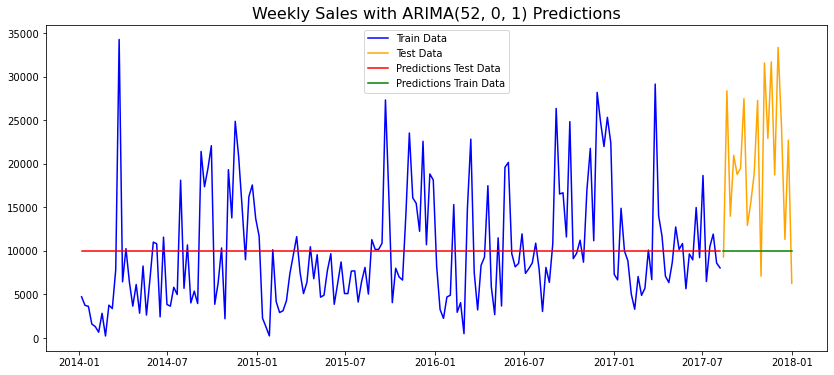

In [34]:
# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.legend()
plt.show();

In [35]:
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

2017-08-14 Predicted: 9969  Actual: 9309 Difference: 1.07
2017-08-21 Predicted: 9969  Actual: 28383 Difference: 0.35
2017-08-28 Predicted: 9969  Actual: 13987 Difference: 0.71
2017-09-04 Predicted: 9969  Actual: 20971 Difference: 0.48
2017-09-11 Predicted: 9969  Actual: 18787 Difference: 0.53
2017-09-18 Predicted: 9969  Actual: 19501 Difference: 0.51
2017-09-25 Predicted: 9969  Actual: 27476 Difference: 0.36
2017-10-02 Predicted: 9969  Actual: 12927 Difference: 0.77
2017-10-09 Predicted: 9969  Actual: 15563 Difference: 0.64
2017-10-16 Predicted: 9969  Actual: 18906 Difference: 0.53
2017-10-23 Predicted: 9969  Actual: 27291 Difference: 0.37


'prediction vs actuals: 0.5146008334828642'

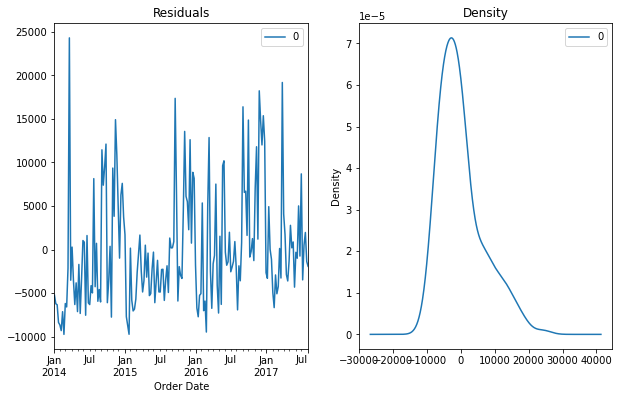

In [36]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [37]:
model.aic

3844.1864103742146

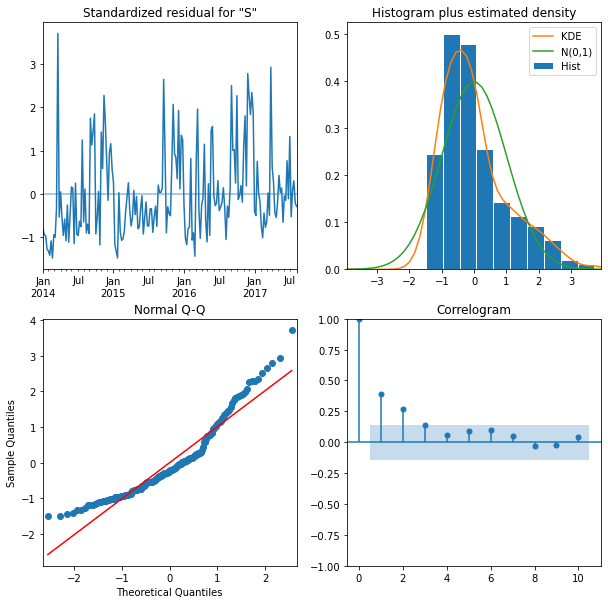

In [38]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()

In [39]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.48508427325210157,
 'mean': -10173.528454311265,
 'mae': 10861.453608861788,
 'mpe': -0.38380416114377247,
 'rmse': 12894.722419017247,
 'corr': nan,
 'minmax': 0.46894675663675955}